# Pollen 

In [1]:
%matplotlib inline
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# pip install opencv-python
import cv2 as cv

In [2]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset

# 
class PollenDataset(Dataset):
    """class for Pollen dataset."""
    
    # 'pollen_data.csv', base_path
    def __init__(self, csv_file, root_dir, transform=None):
        '''
        '''
        self.root_dir = root_dir
        self.imlist = glob.glob(os.path.join(root_dir, 'images', '*.jpg'))
        self.dataframe = pd.read_csv(csv_file, index_col=0)
        
        self.transform = transform
        self.size =(180,300)
        
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        '''
        '''
        img_name = os.path.join(self.root_dir,
                                'images',
                                self.dataframe.iloc[idx, 0])
        
        image = cv.imread(img_name)
        image2 = cv.cvtColor(image, cv.COLOR_RGB2BGR)
        image = cv.resize(image2, self.size)

        label = self.dataframe.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        #image = image.transpose(2,0,1)
        
        return (image, label)
    

# Class to display random image and label
def show_random_sample():
    idx = np.random.randint(len(pollen_data))
    image, label = pollen_data[idx]
    label_dict = {0: 'No pollen', 1: 'Pollen'}
    print(label_dict[label])
    plt.imshow(image);
    
def show_random_samples():
    
    label_dict = {0: 'No pollen', 1: 'Pollen'}
    fig = plt.figure(figsize=(12, 5))
    
    for i in range(6):
        plt.subplot(1,6,i+1)
        plt.tight_layout()
        
        idx = np.random.randint(len(pollen_data))
        image, label = pollen_data[idx]
        
        plt.imshow(image, cmap='gray', interpolation='none')
        plt.title(f"{label_dict[label]}")
        plt.xticks([])
        plt.yticks([])
    fig
    

### Instantiate the PollenDataset:

In [3]:
pollen_data = PollenDataset(csv_file='pollen_data.csv',
                            root_dir='/Users/mattjohnson/DeepLearning/A2/PollenDataset')

#### A look at some samples:

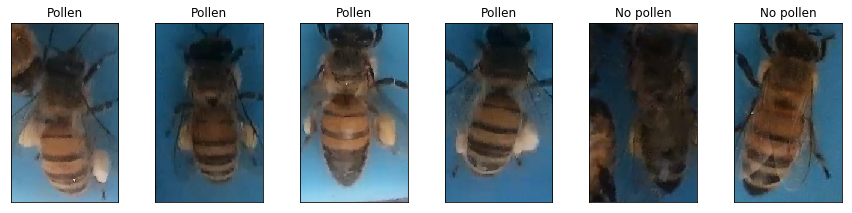

In [4]:
show_random_samples()

### Model Building:

In [5]:
# CNN
#
import torch.nn as nn

class BeeNet(nn.Module):
    def __init__(self):
        super(BeeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.conv3 = nn.Conv2d(32, 2, kernel_size=5)
        self.fc1 = nn.Linear(2*19*34, 50)
        self.fc2 = nn.Linear(50, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        #print('>', x.shape)
        x = x.view(-1,2*19*34)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        #print(x.shape)
        return F.log_softmax(x)

    def name(self):
        return "BeeNet_f24"

### Model training:

In [6]:
from torch.utils.data.sampler import SubsetRandomSampler

def get_training_and_validation_loaders(dataset):
    batch_size = 16
    validation_split = .2
    shuffle_dataset = True
    random_seed = 8

    # Creating data indices for training and validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))

    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(indices)
        
    train_indices, val_indices = indices[split:], indices[:split]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                               sampler=train_sampler)
    validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=valid_sampler)
    
    return train_loader, validation_loader       

In [7]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 
train_loader, validation_loader = get_training_and_validation_loaders(pollen_data)

# HPs
lr = 0.0001

# Model
model = BeeNet().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

loss_list = []
acc_list = []

#
num_epochs = 30
for epoch in range(num_epochs):
    # Train:   
    for batch_index, (images, labels) in enumerate(train_loader):
        # ...
        images, labels = images.to(device), labels.to(device)
        #images = images
        
        # Forward pass
        outputs = model(images.permute(0, 3, 2, 1).float())
           
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_list.append(loss.item())
        
    with torch.no_grad():
        
        losses = []
        total = 0
        correct = 0
    
        for images, labels in validation_loader:
            # ...
            images, labels = images.to(device), labels.to(device)
            images.permute(0, 3, 2, 1).float()
            
            # Forward pass
            outputs = model(images.permute(0, 3, 2, 1).float())
            
            loss = criterion(outputs, labels)
        
            # Compute accuracy
            _, argmax = torch.max(outputs, 1)
            correct += (labels == argmax).sum().item() #.mean()
            total += len(labels)
            
            losses.append(loss.item())
            
        print(f'Step [{epoch+1}/{num_epochs}]')
        try:
            print(f'Loss: {np.mean(losses):.4}, Acc: {correct/total:.2f}')
        except:
            print('correct:', correct, 'total:', total)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Step [1/30]
Loss: 0.696, Acc: 0.49
Step [2/30]
Loss: 0.6887, Acc: 0.51
Step [3/30]
Loss: 0.6678, Acc: 0.54
Step [4/30]
Loss: 0.5999, Acc: 0.60
Step [5/30]
Loss: 0.5978, Acc: 0.65
Step [6/30]
Loss: 0.5915, Acc: 0.68
Step [7/30]
Loss: 0.6553, Acc: 0.71
Step [8/30]
Loss: 0.3628, Acc: 0.82
Step [9/30]
Loss: 0.4657, Acc: 0.81
Step [10/30]
Loss: 0.3799, Acc: 0.83
Step [11/30]
Loss: 0.3513, Acc: 0.89
Step [12/30]
Loss: 0.3737, Acc: 0.86
Step [13/30]
Loss: 0.3071, Acc: 0.87
Step [14/30]
Loss: 0.3179, Acc: 0.89
Step [15/30]
Loss: 0.3242, Acc: 0.85
Step [16/30]
Loss: 0.4001, Acc: 0.83
Step [17/30]
Loss: 0.4002, Acc: 0.87
Step [18/30]
Loss: 0.2445, Acc: 0.91
Step [19/30]
Loss: 0.2945, Acc: 0.89
Step [20/30]
Loss: 0.2881, Acc: 0.88
Step [21/30]
Loss: 0.3352, Acc: 0.90
Step [22/30]
Loss: 0.3353, Acc: 0.89
Step [23/30]
Loss: 0.2424, Acc: 0.89
Step [24/30]
Loss: 0.266, Acc: 0.86
Step [25/30]
Loss: 0.3808, Acc: 0.94
Step [26/30]
Loss: 0.2202, Acc: 0.89
Step [27/30]
Loss: 0.1752, Acc: 0.93
Step [28/30]

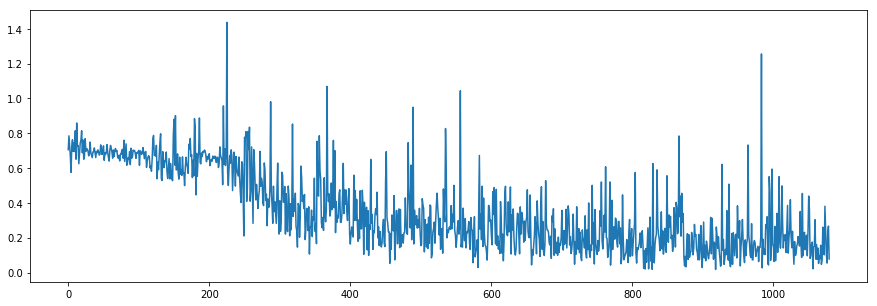

In [8]:
plt.subplots(figsize=(15,5))
plt.plot(loss_list);

In [9]:
torch.save(model.state_dict(), model.name())

In [10]:
images, labels = next(iter(train_loader))

print(images.shape, '-', labels.shape)

torch.Size([16, 300, 180, 3]) - torch.Size([16])


In [11]:
images.shape

torch.Size([16, 300, 180, 3])

In [12]:
images.permute(0, 3, 2, 1).shape

torch.Size([16, 3, 180, 300])

In [13]:
conv1 = nn.Conv2d(3, 64, kernel_size=5)
x = conv1(images.permute(0, 3, 2, 1).float())
print('c1:', x.shape)# torch.Size([16, 300, 176, 296])

c1: torch.Size([16, 64, 176, 296])


In [14]:
mp1 = F.max_pool2d(x, 2)
print('mp1:', mp1.shape)

mp1: torch.Size([16, 64, 88, 148])


In [15]:
relu1 = F.relu(mp1)
print('relu:', relu1.shape)

relu: torch.Size([16, 64, 88, 148])


In [16]:
conv2 = nn.Conv2d(64, 32, kernel_size=5)
c2 = conv2(relu1)
c2.shape

torch.Size([16, 32, 84, 144])

In [17]:
conv2_drop = nn.Dropout2d()
cd = conv2_drop(c2)
cd.shape

torch.Size([16, 32, 84, 144])

In [18]:
mp2 = F.max_pool2d(cd, 2)
mp2.shape

torch.Size([16, 32, 42, 72])

In [19]:
relu2 = F.relu(mp2)
relu2.shape

torch.Size([16, 32, 42, 72])

In [20]:
conv3 = nn.Conv2d(32, 2, kernel_size=5)
c3 = conv3(relu2)
c3.shape

torch.Size([16, 2, 38, 68])

In [21]:
mp3 = F.max_pool2d(c3, 2)
mp3.shape

torch.Size([16, 2, 19, 34])

In [22]:
x = c3.view(-1, 2*38*68)
x.shape

torch.Size([16, 5168])

In [23]:
fc1 = nn.Linear(5168, 50)
fc2 = nn.Linear(50, 2)

In [24]:
x = F.relu(fc1(x))
x.shape

torch.Size([16, 50])

In [25]:
#x = F.dropout(x, training=self.training)


In [26]:
x = fc2(x)
print(x.shape)

torch.Size([16, 2])


In [27]:
x

tensor([[ 0.9402,  0.3564],
        [ 1.3370,  0.6616],
        [ 0.7238,  0.0202],
        [-0.3684, -1.1582],
        [ 1.2196, -0.1215],
        [-0.2629, -0.7224],
        [ 2.8642, -1.2988],
        [ 2.1451,  1.3366],
        [ 1.3746,  0.8240],
        [ 1.3711,  0.0485],
        [ 0.9526,  0.4873],
        [ 1.0594,  0.2547],
        [ 0.2921, -0.2046],
        [-0.2672,  1.9465],
        [ 0.8584,  2.7820],
        [-0.8977,  4.4723]], grad_fn=<AddmmBackward>)

In [28]:
out = F.log_softmax(x, dim=1)
print(out.shape)

torch.Size([16, 2])


In [29]:
out

tensor([[-4.4324e-01, -1.0271e+00],
        [-4.1143e-01, -1.0868e+00],
        [-4.0200e-01, -1.1056e+00],
        [-3.7427e-01, -1.1641e+00],
        [-2.3235e-01, -1.5734e+00],
        [-4.8957e-01, -9.4904e-01],
        [-1.5442e-02, -4.1784e+00],
        [-3.6846e-01, -1.1770e+00],
        [-4.5529e-01, -1.0058e+00],
        [-2.3621e-01, -1.5588e+00],
        [-4.8730e-01, -9.5265e-01],
        [-3.6965e-01, -1.1743e+00],
        [-4.7532e-01, -9.7202e-01],
        [-2.3173e+00, -1.0373e-01],
        [-2.0600e+00, -1.3634e-01],
        [-5.3746e+00, -4.6439e-03]], grad_fn=<LogSoftmaxBackward>)

In [30]:
labels.shape

torch.Size([16])

In [31]:
outputs.shape

torch.Size([14, 2])

In [32]:
torch.max(outputs, 1)[1].shape

torch.Size([14])

In [33]:
# Compute accuracy
correct=0
total=0

_, argmax = torch.max(out, 1)
correct += (labels == argmax).sum().item() #.mean()
total += len(labels)

losses.append(loss.item())

In [34]:
correct

7

In [35]:
total

16

In [36]:
images.shape

torch.Size([16, 300, 180, 3])

In [37]:
with torch.no_grad():
        
        losses = []
        total = 0
        correct = 0
    
        for images, labels in validation_loader:
            # ...
            images, labels = images.to(device), labels.to(device)
            images.permute(0, 3, 2, 1).float()
            
            # Forward pass
            outputs = model(images.permute(0, 3, 2, 1).float())
            
            loss = criterion(outputs, labels)
        
            # Compute accuracy
            _, argmax = torch.max(outputs, 1)
            correct += (labels == argmax).sum().item() #.mean()
            total += len(labels)
            
            losses.append(loss.item())
            
        print(f'Step [{epoch+1}/{num_epochs}]')
        try:
            print(f'Loss: {np.mean(losses):.4}, Acc: {correct/total:.2f}')
            print('correct:', correct)
            print('total:', total)
        except:
            print('correct:', correct)
            print('total:', total)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Step [30/30]
Loss: 0.2275, Acc: 0.91
correct: 129
total: 142


In [38]:
(labels==argmax).sum().item()

14